In [16]:
import os

# Kaggle dataset root path
data_dir = "/kaggle/input/hc18-grand-challenge/training_set/"

# Get all file names
all_files = sorted(os.listdir(data_dir))

# Separate images and masks
image_files = [f for f in all_files if "Annotation" not in f]
mask_files = [f for f in all_files if "Annotation" in f]

# Example: print first 5 matches
for img_file in image_files[:5]:
    mask_file = img_file.replace(".png", "_Annotation.png").replace("2HC", "2HC")  # handle 2HC cases too
    if mask_file in mask_files:
        print(f"Image: {img_file}  <-->  Mask: {mask_file}")


Image: 000_HC.png  <-->  Mask: 000_HC_Annotation.png
Image: 001_HC.png  <-->  Mask: 001_HC_Annotation.png
Image: 002_HC.png  <-->  Mask: 002_HC_Annotation.png
Image: 003_HC.png  <-->  Mask: 003_HC_Annotation.png
Image: 004_HC.png  <-->  Mask: 004_HC_Annotation.png


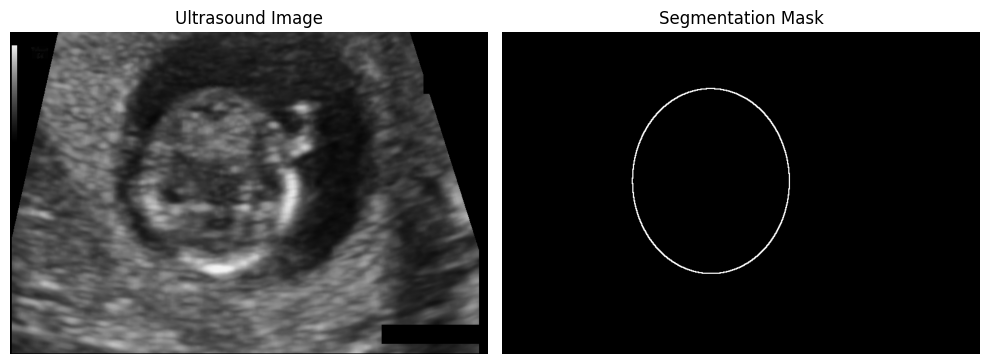

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

img_name = "010_HC.png"
mask_name = "010_HC_Annotation.png"

img = Image.open(os.path.join(data_dir, img_name)).convert("RGB")
mask = Image.open(os.path.join(data_dir, mask_name)).convert("L")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Ultrasound Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Mask")
plt.axis("off")
plt.tight_layout()
plt.show()


In [18]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class HC18Dataset(Dataset):
    def __init__(self, root_dir, image_files, transform=None, image_size=(256, 256)):
        self.root_dir = root_dir
        self.image_files = image_files
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name = image_name.replace(".png", "_Annotation.png")

        image_path = os.path.join(self.root_dir, image_name)
        mask_path = os.path.join(self.root_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Resize both image and mask
        image = image.resize(self.image_size)
        mask = mask.resize(self.image_size)

        # Convert to tensor and normalize
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        # Optional: convert mask to binary (0 or 1)
        mask = (mask > 0).float()

        return image, mask


In [19]:
from torch.utils.data import DataLoader

# Root path
data_dir = "/kaggle/input/hc18-grand-challenge/training_set/"

# Get all image files (not masks)
image_files = sorted([f for f in os.listdir(data_dir) if "_Annotation" not in f])

# Create dataset and dataloader
dataset = HC18Dataset(root_dir=data_dir, image_files=image_files)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


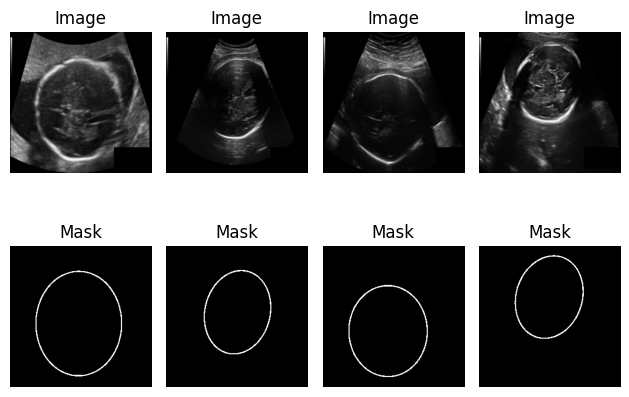

In [20]:
import matplotlib.pyplot as plt

images, masks = next(iter(dataloader))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(2, 4, i+5)
    plt.imshow(masks[i][0], cmap="gray")
    plt.title("Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [21]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        # Final layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]

            if x.shape != skip.shape:
                x = TF.resize(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)


In [22]:
model = UNet(in_channels=3, out_channels=1)
x = torch.randn((1, 3, 256, 256))
with torch.no_grad():
    preds = model(x)

print("Output shape:", preds.shape)


Output shape: torch.Size([1, 1, 256, 256])


# Set Up Training

In [23]:
import torch.optim as optim
import torch.nn.functional as F

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Dice Score metric
def dice_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

    dice = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice.mean()


# Training Loop

In [24]:
from tqdm import tqdm

def train(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    dice_total = 0

    loop = tqdm(loader, desc="Training", leave=False)
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = combined_loss(outputs, masks)
        dice = dice_score(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        dice_total += dice.item()

        loop.set_postfix(loss=loss.item(), dice=dice.item())

    avg_loss = epoch_loss / len(loader)
    avg_dice = dice_total / len(loader)
    return avg_loss, avg_dice


# Train the Model

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    loss, dice = train(model, dataloader, optimizer, criterion, device)
    print(f"Loss: {loss:.4f}, Dice: {dice:.4f}")



Epoch 1/20


Loss: 1.1900, Dice: 0.3358

Epoch 2/20


Loss: 1.0238, Dice: 0.4152

Epoch 3/20


Loss: 0.9150, Dice: 0.4340

Epoch 4/20


Loss: 0.8202, Dice: 0.4536

Epoch 5/20


Loss: 0.7390, Dice: 0.4753

Epoch 6/20


Loss: 0.6800, Dice: 0.4898

Epoch 7/20


Loss: 0.6380, Dice: 0.5028

Epoch 8/20


Loss: 0.5973, Dice: 0.5242

Epoch 9/20


Loss: 0.5661, Dice: 0.5419

Epoch 10/20


Loss: 0.5281, Dice: 0.5694

Epoch 11/20


Loss: 0.5055, Dice: 0.5843

Epoch 12/20


Loss: 0.4740, Dice: 0.6089

Epoch 13/20


Loss: 0.4403, Dice: 0.6358

Epoch 14/20


Loss: 0.4189, Dice: 0.6521

Epoch 15/20


Loss: 0.3896, Dice: 0.6761

Epoch 16/20


Loss: 0.3621, Dice: 0.6989

Epoch 17/20


Loss: 0.3452, Dice: 0.7123

Epoch 18/20


Loss: 0.3242, Dice: 0.7295

Epoch 19/20


Loss: 0.3048, Dice: 0.7455

Epoch 20/20


Loss: 0.2913, Dice: 0.7564


In [29]:
def dice_loss(preds, targets, smooth=1e-8):
    preds = torch.sigmoid(preds)
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(preds, targets):
    bce = F.binary_cross_entropy_with_logits(preds, targets)
    dsc = dice_loss(preds, targets)
    return bce + dsc


#   Save the Model (after training)

In [30]:
torch.save(model.state_dict(), "/kaggle/working/unet_hc18.pth")
print("Model saved to /kaggle/working/unet_hc18.pth")


Model saved to /kaggle/working/unet_hc18.pth


#  Visualize Predictions

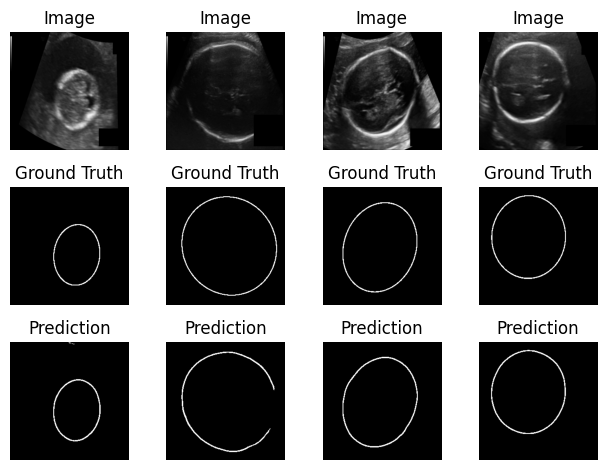

In [32]:
model.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)                      # raw logits
        preds = torch.sigmoid(outputs)               # convert to probability
        preds = (preds > 0.5).float()                # threshold to binary mask

        # Visualize first 4 samples
        for i in range(4):
            plt.subplot(3, 4, i+1)
            plt.imshow(images[i].cpu().permute(1,2,0))
            plt.title("Image")
            plt.axis("off")

            plt.subplot(3, 4, i+5)
            plt.imshow(masks[i][0].cpu(), cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(3, 4, i+9)
            plt.imshow(preds[i][0].cpu(), cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break
